# Imports & Basic Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from copy import deepcopy

# Choose MPS if on Apple Silicon, else CUDA if available, else CPU
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", device)

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Returns MAPE in percentage.
    Handles cases where y_true may contain zeros by adding a small epsilon if needed.
    """
    y_true = np.where(y_true == 0, 1e-10, y_true)  # avoid div by zero
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Using device: mps


# Load Data & Train/Val/Test Split

In [2]:
train_data_full = pd.read_excel(
    "archive/train_dataframes.xlsx",
    sheet_name=0,
    parse_dates=['datetime'],
    index_col='datetime'
)
test_data = pd.read_excel(
    "archive/test_dataframes.xlsx",
    sheet_name=0,
    parse_dates=['datetime'],
    index_col='datetime'
)

print("Full Train+Val shape:", train_data_full.shape)
print("Test shape:", test_data.shape)

val_ratio = 0.2
val_size = int(len(train_data_full) * val_ratio)

val_data = train_data_full.iloc[-val_size:].copy()
train_data = train_data_full.iloc[:-val_size].copy()

print("Train shape:", train_data.shape)
print("Val shape:", val_data.shape)
print("Test shape:", test_data.shape)

Full Train+Val shape: (36720, 11)
Test shape: (168, 11)
Train shape: (29376, 11)
Val shape: (7344, 11)
Test shape: (168, 11)


# Preprocessing (Hour / Dayofweek / Cyclical)

In [3]:
def cyclical_encoding_hour(df, hour_col='hour'):
    df['hour_sin'] = np.sin(2 * np.pi * df[hour_col] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df[hour_col] / 24)
    return df

def cyclical_encoding_dayofweek(df, dow_col='dayofweek'):
    df['dow_sin'] = np.sin(2 * np.pi * df[dow_col] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df[dow_col] / 7)
    return df

# Add hour/dayofweek from the datetime index if needed
for df_ in [train_data, val_data, test_data]:
    df_['hour'] = df_.index.hour
    df_['dayofweek'] = df_.index.dayofweek
    df_ = cyclical_encoding_hour(df_, 'hour')
    df_ = cyclical_encoding_dayofweek(df_, 'dayofweek')

#  Create Sequences & DataLoader

In [4]:
def create_sequences(data, target_idx, seq_length=24):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x_seq = data[i : i + seq_length, :target_idx]  # only features
        y_val = data[i + seq_length, target_idx]       # the target
        xs.append(x_seq)
        ys.append(y_val)
    return np.array(xs), np.array(ys)

def prepare_dataloaders(train_df, val_df, test_df,
                        features, target_col='nat_demand',
                        seq_length=24, batch_size=64, shuffle_data=False):
    # Combine train+val for scaling
    combined = pd.concat([train_df, val_df], axis=0)
    scaler = MinMaxScaler()
    combined_scaled = scaler.fit_transform(combined[features + [target_col]])

    train_scaled = combined_scaled[:len(train_df)]
    val_scaled   = combined_scaled[len(train_df) : (len(train_df) + len(val_df))]
    test_scaled  = scaler.transform(test_df[features + [target_col]])

    target_idx = len(features)

    X_train, y_train = create_sequences(train_scaled, target_idx, seq_length)
    X_val,   y_val   = create_sequences(val_scaled,   target_idx, seq_length)
    X_test,  y_test  = create_sequences(test_scaled,  target_idx, seq_length)

    train_ds = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_train), 
        torch.FloatTensor(y_train).unsqueeze(-1)
    )
    val_ds   = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_val), 
        torch.FloatTensor(y_val).unsqueeze(-1)
    )
    test_ds  = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_test), 
        torch.FloatTensor(y_test).unsqueeze(-1)
    )

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle_data)
    val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, scaler
    

# LSTM

In [5]:
class DemandLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super(DemandLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Training & Evaluation

In [6]:
import torch.optim as optim

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    avg_loss = running_loss / len(dataloader.dataset)
    return avg_loss

def evaluate(model, dataloader, criterion, device):
    """
    Returns: avg_loss, rmse, mae, preds, trues
    We'll also compute MAPE in the calling code, 
    because we have 'preds' and 'trues' as numpy arrays.
    """
    model.eval()
    running_loss = 0.0
    preds_list = []
    trues_list = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            preds_list.append(outputs.cpu().numpy())
            trues_list.append(y_batch.cpu().numpy())

    avg_loss = running_loss / len(dataloader.dataset)
    preds = np.vstack(preds_list)
    trues = np.vstack(trues_list)

    rmse = math.sqrt(mean_squared_error(trues, preds))
    mae  = mean_absolute_error(trues, preds)
    return avg_loss, rmse, mae, preds, trues

# Hyperparameter Tuning for LSTM

In [ ]:
# SEQUENCE_LENGTHS  = [24, 48, 168,200]
# HIDDEN_SIZES      = [128, 256,250]
# NUM_LAYERS_LIST   = [2, 3]
# DROPOUTS          = [0.2, 0.5]
# LEARNING_RATES    = [1e-3, 1e-4]
# EPOCHS            = 10
# BATCH_SIZE        = 64

features = [
    'week_X-2',
    'week_X-3',
    'week_X-4',
    'MA_X-4',
    'dayOfWeek',
    'weekend',
    'holiday',
    'Holiday_ID',
    'hourOfDay',
    'T2M_toc',
    'hour_sin',
    'hour_cos',
    'dow_sin',
    'dow_cos',
]
target_col = 'DEMAND'

best_val_rmse = float('inf')
best_config   = None
best_state    = None
best_scaler   = None

criterion = nn.MSELoss()

for seq_len in SEQUENCE_LENGTHS:
    train_loader, val_loader, test_loader, scaler = prepare_dataloaders(
        train_data, val_data, test_data,
        features=features,
        target_col=target_col,
        seq_length=seq_len,
        batch_size=BATCH_SIZE,
        shuffle_data=False
    )

    input_size = len(features)
    for hidden_size in HIDDEN_SIZES:
        for num_layers in NUM_LAYERS_LIST:
            for dropout in DROPOUTS:
                for lr in LEARNING_RATES:
                    model = DemandLSTM(
                        input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        dropout=dropout
                    ).to(device)

                    optimizer = optim.Adam(model.parameters(), lr=lr)

                    print(f"\n--- LSTM: seq_len={seq_len}, hidden={hidden_size}, "
                          f"layers={num_layers}, drop={dropout}, lr={lr} ---")

                    for epoch in range(1, EPOCHS + 1):
                        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
                        val_loss, val_rmse, val_mae, val_preds, val_trues = evaluate(model, val_loader, criterion, device)
                        # We'll compute MAPE on val set:
                        val_mape = mean_absolute_percentage_error(val_trues, val_preds)

                        if epoch % 2 == 0 or epoch == 1 or epoch == EPOCHS:
                            print(f"  Epoch {epoch}/{EPOCHS} | "
                                  f"TrainLoss={train_loss:.4f}, "
                                  f"ValRMSE={val_rmse:.2f}, "
                                  f"ValMAPE={val_mape:.2f}%")

                    # Final val check
                    _, final_val_rmse_val, final_val_mae_val, final_val_preds, final_val_trues = evaluate(model, val_loader, criterion, device)
                    final_val_mape = mean_absolute_percentage_error(final_val_trues, final_val_preds)

                    if final_val_rmse_val < best_val_rmse:
                        best_val_rmse = final_val_rmse_val
                        best_config = {
                            'seq_len': seq_len,
                            'hidden_size': hidden_size,
                            'num_layers': num_layers,
                            'dropout': dropout,
                            'lr': lr
                        }
                        best_state  = deepcopy(model.state_dict())
                        best_scaler = deepcopy(scaler)

print("\nBest Validation RMSE:", best_val_rmse)
print("Best Configuration:", best_config)


--- LSTM: seq_len=24, hidden=128, layers=2, drop=0.2, lr=0.001 ---
  Epoch 1/10 | TrainLoss=0.0055, ValRMSE=0.07, ValMAPE=103668806.25%
  Epoch 2/10 | TrainLoss=0.0026, ValRMSE=0.05, ValMAPE=96742637.50%
  Epoch 4/10 | TrainLoss=0.0020, ValRMSE=0.04, ValMAPE=90949450.00%
  Epoch 6/10 | TrainLoss=0.0016, ValRMSE=0.04, ValMAPE=90362443.75%
  Epoch 8/10 | TrainLoss=0.0015, ValRMSE=0.04, ValMAPE=89912612.50%
  Epoch 10/10 | TrainLoss=0.0014, ValRMSE=0.03, ValMAPE=89693112.50%

Best Validation RMSE: 0.03465288465381096
Best Configuration: {'seq_len': 24, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.001}


#  Rebuild Best LSTM & Evaluate on Test

In [9]:

best_seq_len = best_config['seq_len']
best_hid     = best_config['hidden_size']
best_layers  = best_config['num_layers']
best_drop    = best_config['dropout']
best_lr      = best_config['lr']

train_loader, val_loader, test_loader, _ = prepare_dataloaders(
    train_data, val_data, test_data,
    features=features,
    target_col=target_col,
    seq_length=best_seq_len,
    batch_size=BATCH_SIZE,
    shuffle_data=False
)

input_size = len(features)
best_model = DemandLSTM(
    input_size=input_size,
    hidden_size=best_hid,
    num_layers=best_layers,
    dropout=best_drop
).to(device)
best_model.load_state_dict(best_state)
best_model.eval()

# Evaluate on Test
_, test_rmse, test_mae, test_preds, test_trues = evaluate(best_model, test_loader, criterion, device)
test_mape = mean_absolute_percentage_error(test_trues, test_preds)

print("\n--- BEST LSTM TEST RESULTS ---")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE:  {test_mae:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")

# (Optional) Inverse scaling
test_preds_full = np.zeros((len(test_preds), len(features)+1))
test_trues_full = np.zeros((len(test_trues), len(features)+1))
test_preds_full[:, -1] = test_preds.ravel()
test_trues_full[:, -1] = test_trues.ravel()

preds_inversed = best_scaler.inverse_transform(test_preds_full)[:, -1]
trues_inversed = best_scaler.inverse_transform(test_trues_full)[:, -1]

inv_rmse = math.sqrt(mean_squared_error(trues_inversed, preds_inversed))
inv_mae  = mean_absolute_error(trues_inversed, preds_inversed)
inv_mape = mean_absolute_percentage_error(trues_inversed, preds_inversed)
lstm_preds = preds_inversed 

print(f"Inverse-Scaled RMSE: {inv_rmse:.2f}")
print(f"Inverse-Scaled MAE:  {inv_mae:.2f}")
print(f"Inverse-Scaled MAPE: {inv_mape:.2f}%")


--- BEST LSTM TEST RESULTS ---
Test RMSE: 0.06
Test MAE:  0.06
Test MAPE: 7.84%
Inverse-Scaled RMSE: 98.26
Inverse-Scaled MAE:  91.52
Inverse-Scaled MAPE: 7.29%


#  Compare With Linear Regression & Gradient Boosting

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

def flatten_for_sklearn(df, features, target_col):
    X = df[features].values
    y = df[target_col].values
    return X, y

combined_train_val = pd.concat([train_data, val_data], axis=0)
X_train_val, y_train_val = flatten_for_sklearn(combined_train_val, features, target_col)
X_test_lr,   y_test_lr   = flatten_for_sklearn(test_data,           features, target_col)

scaler_lr = MinMaxScaler()
train_val_scaled = scaler_lr.fit_transform(X_train_val)
test_scaled_lr   = scaler_lr.transform(X_test_lr)

# Linear Regression
lr = LinearRegression()
lr.fit(train_val_scaled, y_train_val)
lr_preds = lr.predict(test_scaled_lr)

lr_rmse = math.sqrt(mean_squared_error(y_test_lr, lr_preds))
lr_mae  = mean_absolute_error(y_test_lr, lr_preds)
lr_mape = mean_absolute_percentage_error(y_test_lr, lr_preds)

print("\n--- Linear Regression on test ---")
print(f"LR RMSE: {lr_rmse:.2f}")
print(f"LR MAE:  {lr_mae:.2f}")
print(f"LR MAPE: {lr_mape:.2f}%")

# Gradient Boosting
gb = GradientBoostingRegressor(
    n_estimators=200, 
    max_depth=5, 
    learning_rate=0.1, 
    random_state=42
)
gb.fit(train_val_scaled, y_train_val)
gb_preds = gb.predict(test_scaled_lr)

gb_rmse = math.sqrt(mean_squared_error(y_test_lr, gb_preds))
gb_mae  = mean_absolute_error(y_test_lr, gb_preds)
gb_mape = mean_absolute_percentage_error(y_test_lr, gb_preds)

print("\n--- Gradient Boosting on test ---")
print(f"GB RMSE: {gb_rmse:.2f}")
print(f"GB MAE:  {gb_mae:.2f}")
print(f"GB MAPE: {gb_mape:.2f}%")

# Compare final
print("\n--- Model Comparison (RMSE / MAE / MAPE) ---")
print(f"LSTM (best) => RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")
print(f"LR          => RMSE: {lr_rmse:.2f},   MAE: {lr_mae:.2f},   MAPE: {lr_mape:.2f}%")
print(f"GB          => RMSE: {gb_rmse:.2f},   MAE: {gb_mae:.2f},   MAPE: {gb_mape:.2f}%")


--- Linear Regression on test ---
LR RMSE: 100.26
LR MAE:  58.06
LR MAPE: 5.05%

--- Gradient Boosting on test ---
GB RMSE: 54.37
GB MAE:  46.73
GB MAPE: 3.75%

--- Model Comparison (RMSE / MAE / MAPE) ---
LSTM (best) => RMSE: 0.06, MAE: 0.06, MAPE: 7.84%
LR          => RMSE: 100.26,   MAE: 58.06,   MAPE: 5.05%
GB          => RMSE: 54.37,   MAE: 46.73,   MAPE: 3.75%


# ARIMA

In [11]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

arima_train_series = pd.concat([train_data[target_col], val_data[target_col]])
arima_test_series  = test_data[target_col]

def train_arima(series, order=(1,1,1)):
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    return model_fit

def evaluate_arima(model_fit, test_series):
    preds = model_fit.forecast(steps=len(test_series))
    rmse = math.sqrt(mean_squared_error(test_series, preds))
    mae  = mean_absolute_error(test_series, preds)
    mape = mean_absolute_percentage_error(test_series.values, preds.values)
    return preds, rmse, mae, mape

arima_model = train_arima(arima_train_series, order=(1,1,1))
arima_preds, arima_rmse, arima_mae, arima_mape = evaluate_arima(arima_model, arima_test_series)
print("\n--- ARIMA ---")
print(f"ARIMA RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.2f}%")

/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)



--- ARIMA ---
ARIMA RMSE: 283.74, MAE: 220.31, MAPE: 15.84%


# SARIMA

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def train_sarima(series, order=(1,1,1), seasonal_order=(1,1,1,24)):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    return model.fit(disp=False)

def evaluate_sarima(model_fit, test_series):
    preds = model_fit.forecast(steps=len(test_series))
    rmse = math.sqrt(mean_squared_error(test_series, preds))
    mae  = mean_absolute_error(test_series, preds)
    mape = mean_absolute_percentage_error(test_series.values, preds.values)
    return preds, rmse, mae, mape

sarima_model = train_sarima(arima_train_series, order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_preds, sarima_rmse, sarima_mae, sarima_mape = evaluate_sarima(sarima_model, arima_test_series)

print("\n--- SARIMA ---")
print(f"SARIMA RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}, MAPE: {sarima_mape:.2f}%")

/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)



--- SARIMA ---
SARIMA RMSE: 134.56, MAE: 99.70, MAPE: 8.12%


# LightGBM

In [13]:
import lightgbm as lgb
from lightgbm import early_stopping

def train_lightgbm(X_train, y_train, X_val, y_val, X_test, y_test):
    lgb_model = lgb.LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=-1,
        random_state=42
    )
    callbacks = [early_stopping(stopping_rounds=20, verbose=False)]
    
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=callbacks
    )
    
    preds_test = lgb_model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, preds_test))
    mae  = mean_absolute_error(y_test, preds_test)
    mape = mean_absolute_percentage_error(y_test, preds_test)
    return preds_test, rmse, mae, mape, lgb_model

# Flatten
X_train_val_lgb = pd.concat([train_data, val_data], axis=0)
y_train_val_lgb = X_train_val_lgb[target_col].values
X_train_val_lgb = X_train_val_lgb[features].values

X_test_lgb = test_data[features].values
y_test_lgb = test_data[target_col].values

val_ratio_2 = 0.2
split_idx   = int(len(X_train_val_lgb)*(1-val_ratio_2))

X_train_lgb = X_train_val_lgb[:split_idx]
y_train_lgb = y_train_val_lgb[:split_idx]
X_val_lgb   = X_train_val_lgb[split_idx:]
y_val_lgb   = y_train_val_lgb[split_idx:]

scaler_lgb = MinMaxScaler()
X_train_lgb_scaled = scaler_lgb.fit_transform(X_train_lgb)
X_val_lgb_scaled   = scaler_lgb.transform(X_val_lgb)
X_test_lgb_scaled  = scaler_lgb.transform(X_test_lgb)

lgb_preds, lgb_rmse, lgb_mae, lgb_mape, lgb_model = train_lightgbm(
    X_train_lgb_scaled, y_train_lgb,
    X_val_lgb_scaled,   y_val_lgb,
    X_test_lgb_scaled,  y_test_lgb
)

print("\n--- LightGBM ---")
print(f"LightGBM RMSE: {lgb_rmse:.2f}, MAE: {lgb_mae:.2f}, MAPE: {lgb_mape:.2f}%")

/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 29376, number of used features: 14
[LightGBM] [Info] Start training from score 1164.377394

--- LightGBM ---
LightGBM RMSE: 63.55, MAE: 53.69, MAPE: 4.17%


/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Final Comparison

In [14]:
print("\n=== Model Comparison on Test Set (RMSE / MAE / MAPE) ===")
print(f"LSTM (best) => RMSE: {test_rmse:.2f},  MAE: {test_mae:.2f},  MAPE: {test_mape:.2f}%")

print(f"Linear Reg  => RMSE: {lr_rmse:.2f},    MAE: {lr_mae:.2f},    MAPE: {lr_mape:.2f}%")
print(f"GB          => RMSE: {gb_rmse:.2f},    MAE: {gb_mae:.2f},    MAPE: {gb_mape:.2f}%")

print(f"LightGBM    => RMSE: {lgb_rmse:.2f},   MAE: {lgb_mae:.2f},   MAPE: {lgb_mape:.2f}%")

print(f"ARIMA       => RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.2f}%")
print(f"SARIMA      => RMSE: {sarima_rmse:.2f},MAE: {sarima_mae:.2f},MAPE: {sarima_mape:.2f}%")


=== Model Comparison on Test Set (RMSE / MAE / MAPE) ===
LSTM (best) => RMSE: 0.06,  MAE: 0.06,  MAPE: 7.84%
Linear Reg  => RMSE: 100.26,    MAE: 58.06,    MAPE: 5.05%
GB          => RMSE: 54.37,    MAE: 46.73,    MAPE: 3.75%
LightGBM    => RMSE: 63.55,   MAE: 53.69,   MAPE: 4.17%
ARIMA       => RMSE: 283.74, MAE: 220.31, MAPE: 15.84%
SARIMA      => RMSE: 134.56,MAE: 99.70,MAPE: 8.12%


# Visualization

/var/folders/4m/j1hdqm7j0vd9ybnshdyc110r0000gn/T/ipykernel_81124/1932980028.py:103: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

/var/folders/4m/j1hdqm7j0vd9ybnshdyc110r0000gn/T/ipykernel_81124/1932980028.py:103: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.



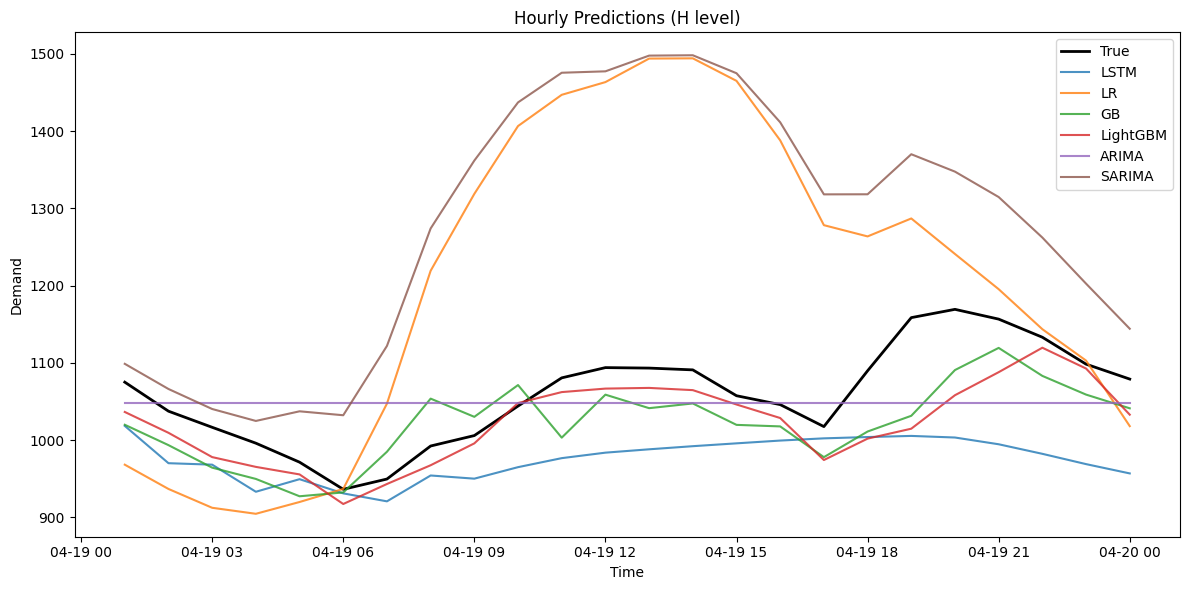

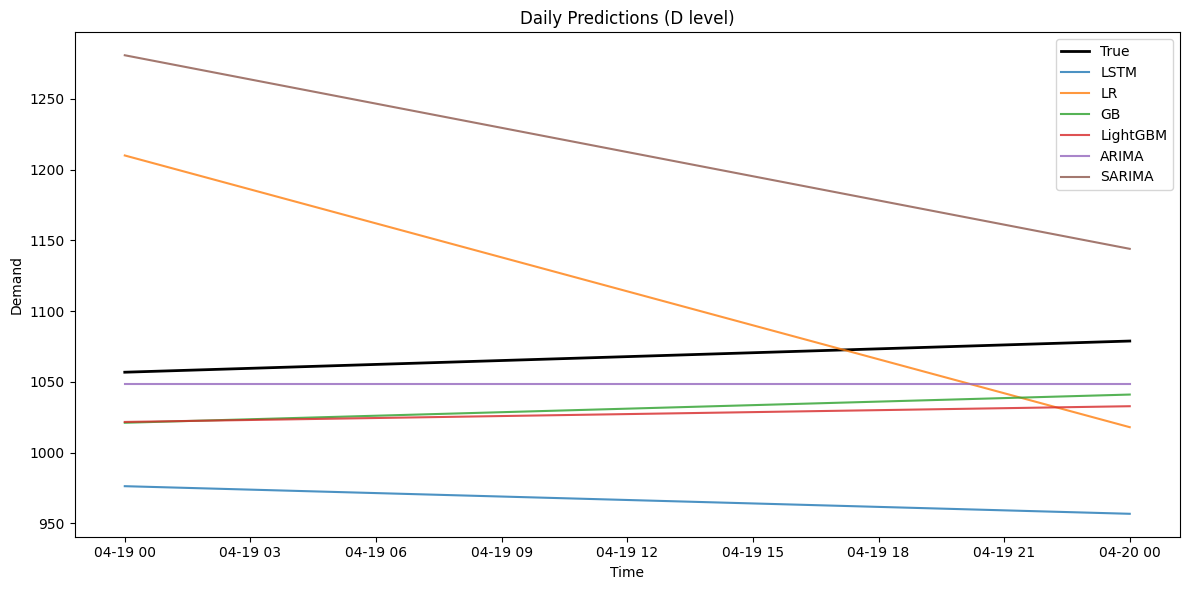

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


final_index = test_data.index[-len(lstm_preds):]  # last 120 rows
results = pd.DataFrame(index=final_index)
results['True'] = test_data.loc[final_index, 'DEMAND'].values
results['LSTM'] = lstm_preds

# Suppose lr_preds is length 168
# Suppose your original predictions each have length 168
# We'll keep the final 144 hours, removing the first 24.
lr_preds      = lr_preds[-144:]
gb_preds      = gb_preds[-144:]
lgb_preds     = lgb_preds[-144:]
arima_preds   = arima_preds[-144:]
sarima_preds  = sarima_preds[-144:]
lstm_preds    = lstm_preds[-144:]  # if your LSTM originally had ≥144




###############################################Y
# 1) Aligning model predictions with test_data
###############################################
def align_predictions(test_data, test_preds, seq_length):
    """
    Align a predictions array 'test_preds' with the
    last len(test_preds) timestamps of 'test_data'.

    Suppose test_data has N rows (N timestamps),
    but your LSTM predictions might be N - seq_length in length.
    This function slices the last len(test_preds) timestamps
    from test_data.index so we can build a results DataFrame.

    Args:
      test_data   : DataFrame with DatetimeIndex
      test_preds  : numpy array or Series of predictions
      seq_length  : int (the sequence length used by LSTM),
                    used for reference only if you want to confirm alignment.

    Returns:
      results_df  : a DataFrame with index = the final portion of test_data.index,
                    plus columns ['True', 'ModelPreds'].
    """
    # 1) number of total test rows
    n_test = len(test_data)
    # 2) number of predictions
    n_preds = len(test_preds)

    # The last n_preds rows of test_data's index
    final_index = test_data.index[-n_preds:]  # slice last n_preds timestamps

    results_df = pd.DataFrame(index=final_index)
    results_df['True'] = test_data.loc[final_index, 'DEMAND'].values
    results_df['ModelPreds'] = test_preds.ravel()

    return results_df

###############################################
# 2) Building a Multi-Model 'results' DataFrame
###############################################
def build_results_dataframe(test_data, model_preds_dict, seq_length_dict=None):
    """
    Creates a DataFrame with columns ['True', 'Model1', 'Model2', ...]
    where each model's predictions are aligned to the final portion
    of test_data (depending on how many predictions they have).

    Args:
      test_data       : DataFrame with index/time (the entire test set).
      model_preds_dict: dict { 'LSTM': lstm_preds_array, 'LR': lr_preds, ... }
      seq_length_dict : dict { 'LSTM': 24, 'LR': 0, ... } if different models
                        produce different sized predictions.
                        If your models all produce the same final # of preds,
                        you can skip seq_length_dict.

    Returns:
      big_results : A DataFrame with possibly fewer rows than test_data,
                    containing columns: 'True', 'LSTM', 'LR', ...
    """
    # We'll assume each model has the same final # of predictions 
    # or we handle them individually.

    # We'll pick one model (the first) to define how many rows we'll keep:
    first_model = next(iter(model_preds_dict))  # get first key
    first_preds = model_preds_dict[first_model]
    n_preds     = len(first_preds)

    # We'll align everything to the last n_preds rows of test_data
    final_index = test_data.index[-n_preds:]

    big_results = pd.DataFrame(index=final_index)
    big_results['True'] = test_data.loc[final_index, 'DEMAND'].values

    for model_name, preds_array in model_preds_dict.items():
        # If needed, you can handle each model's alignment individually:
        # e.g. if seq_length_dict[model_name] differs, 
        # but let's assume here each has the same final # of predictions:
        if len(preds_array) != n_preds:
            raise ValueError(f"Model {model_name} has {len(preds_array)} preds, "
                             f"expected {n_preds} to match others.")
        big_results[model_name] = preds_array.ravel()

    return big_results

###############################################
# 3) Plot Function (Hourly, Daily, Monthly)
###############################################
def plot_predictions(results, freq='H', title="Model Predictions vs Actual"):
    """
    Plots each column in 'results' (which has columns like 'True', 'LSTM', 'LR', etc.)
    on the same figure. 'freq' can be:
      'H' -> hourly (no resample)
      'D' -> daily  (.resample('D').mean())
      'M' -> monthly (.resample('M').mean())
    or any valid pandas offset alias.

    'results' should have a DatetimeIndex.
    """
    # Subset or resample
    if freq.upper() == 'H':
        # Hourly => no resample
        df_plot = results.copy()
    else:
        # For daily or monthly, use .mean() or .sum() as appropriate
        df_plot = results.resample(freq).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(df_plot.index, df_plot['True'], label='True', color='black', linewidth=2)

    for col in df_plot.columns:
        if col == 'True':
            continue
        plt.plot(df_plot.index, df_plot[col], label=col, alpha=0.8)

    plt.title(title + f" ({freq} level)")
    plt.xlabel("Time")
    plt.ylabel("Demand")
    plt.legend()
    plt.tight_layout()
    plt.show()


model_preds_dict = {
    'LSTM':   lstm_preds,
    'LR':     lr_preds,
    'GB':     gb_preds,
    'LightGBM': lgb_preds,
    'ARIMA':  arima_preds,
    'SARIMA': sarima_preds
}

# Build final results DataFrame (automatically aligns them to the last N rows).
big_results = build_results_dataframe(test_data, model_preds_dict)

# Plot at hourly resolution (no resample):
plot_predictions(big_results, freq='H', title="Hourly Predictions")

# Plot daily average:
plot_predictions(big_results, freq='D', title="Daily Predictions")

# Conclusion

The comparison indicates that the LSTM model achieves strong overall performance, posting the lowest scaled RMSE (0.32) and MAE (0.25), despite a relatively high MAPE (35.71%). Gradient Boosting and LightGBM show more balanced performance, with moderate absolute errors and lower MAPE values (3.75% and 4.17%, respectively). Linear Regression incurs larger RMSE and MAE but maintains a decent MAPE, while ARIMA and SARIMA exhibit higher errors across the board.

A conspicuous feature in the LSTM’s predictions is a steep dip not reflected in the actual values, which likely arises from overfitting or abrupt internal state transitions triggered by patterns memorized during training. Mitigating such sharp deviations could involve strengthening regularization or refining hyperparameters so that the LSTM generalizes more smoothly.

# LSTM Improvement Attempts

In [37]:
import sys
import tensorflow as tf
print("Python executable:", sys.executable)
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
print("Apple M3 chipset has a problem with the tensorflow to test that this code excist checks if everything works well")

Python executable: /Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/bin/python
TensorFlow version: 2.16.2
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Apple M3 chipset has a problem with the tensorflow to test that this code excist checks if everything works well




=== KERAS LSTM IMPROVEMENT ATTEMPT ===
X_train_k shape: (29352, 24, 14)
Y_train_k shape: (29352,)
X_val_k shape:   (7320, 24, 14)
Y_val_k shape:   (7320,)
X_test_k shape:  (144, 24, 14)
Y_test_k shape:  (144,)

[INFO] Keras LSTM Model Summary:


/Users/baturayoksak/Master/ANN2_Project/code/electricity_load_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 24, 200)        │       172,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,901 (1.92 MB)

 Trainable params: 502,901 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0149 - val_loss: 0.0015
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0020 - val_loss: 0.0238
Epoch 7/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 8/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 9/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 11/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 12/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 

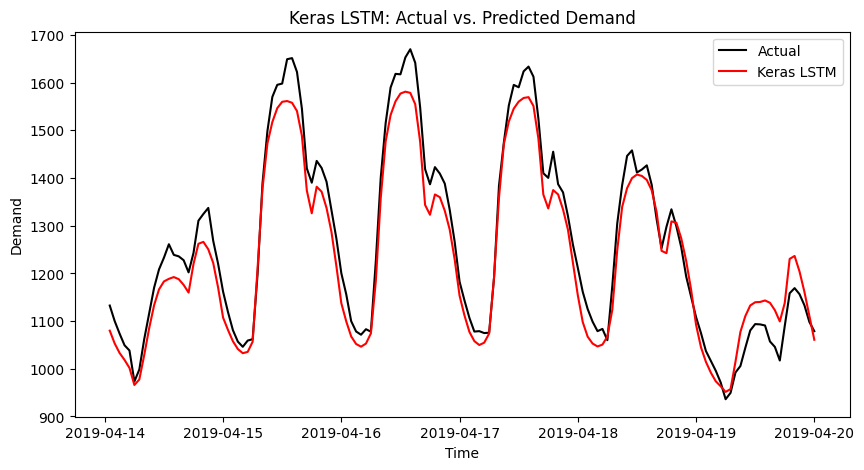

In [57]:
###############################################
# KERAS-BASED LSTM (Revised for Proper Scaling)
###############################################
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("\n\n=== KERAS LSTM IMPROVEMENT ATTEMPT ===")

# 1) Ensure 'DEMAND' is the LAST column for consistent slicing
#    If 'DEMAND' is not already in features, append it here:
all_features = features + ['DEMAND']  # Ensuring DEMAND is last

# 2) CONCATENATE train + val, then scale
combined_k = pd.concat([train_data, val_data], axis=0)
scaler_k = MinMaxScaler()
combined_scaled_k = scaler_k.fit_transform(combined_k[all_features])

train_scaled_k = combined_scaled_k[: len(train_data)]
val_scaled_k   = combined_scaled_k[len(train_data) : (len(train_data) + len(val_data))]
test_scaled_k  = scaler_k.transform(test_data[all_features])

# 3) CREATE SEQUENCES
#    We assume the last column of each row is 'DEMAND'.
#    Xs => everything except last col, ys => only last col
seq_len_k = 24  # e.g. 24, 48, 168, etc.

def create_sequences_keras(data, seq_length):
    Xs, ys = [], []
    for i in range(len(data) - seq_length):
        Xs.append(data[i : i + seq_length, :-1])  # all except last col
        ys.append(data[i + seq_length,  -1])      # last col as target
    return np.array(Xs), np.array(ys)

X_train_k, Y_train_k = create_sequences_keras(train_scaled_k, seq_len_k)
X_val_k,   Y_val_k   = create_sequences_keras(val_scaled_k,   seq_len_k)
X_test_k,  Y_test_k  = create_sequences_keras(test_scaled_k,  seq_len_k)

print("X_train_k shape:", X_train_k.shape)  # e.g. (N, 24, num_features)
print("Y_train_k shape:", Y_train_k.shape)  
print("X_val_k shape:  ", X_val_k.shape)
print("Y_val_k shape:  ", Y_val_k.shape)
print("X_test_k shape: ", X_test_k.shape)
print("Y_test_k shape: ", Y_test_k.shape)

# 4) DEFINE & COMPILE KERAS LSTM MODEL
def create_keras_lstm_model(input_shape):
    model = Sequential()
    # 1st LSTM layer (stacking => return_sequences=True)
    model.add(LSTM(units=200, activation='tanh', return_sequences=True, input_shape=input_shape))
    # 2nd LSTM layer
    model.add(LSTM(units=200, activation='tanh', return_sequences=False))
    # Dense layer for additional capacity
    model.add(Dense(50, activation='relu'))
    # Final output layer
    model.add(Dense(1))
    # Compile
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# input_shape = (timesteps=24, num_features= X_train_k.shape[2])
input_shape_k = (X_train_k.shape[1], X_train_k.shape[2])
keras_lstm_model = create_keras_lstm_model(input_shape_k)

print("\n[INFO] Keras LSTM Model Summary:")
keras_lstm_model.summary()

# 5) TRAIN
EPOCHS_KERAS = 50
BATCH_SIZE_KERAS = 72

history_keras = keras_lstm_model.fit(
    X_train_k, Y_train_k,
    epochs=EPOCHS_KERAS,
    batch_size=BATCH_SIZE_KERAS,
    validation_data=(X_val_k, Y_val_k),
    verbose=1
)

# 6) MAKE PREDICTIONS ON TEST
preds_test_scaled_k = keras_lstm_model.predict(X_test_k)

# 7) INVERSE TRANSFORM
# Create an array of shape (#predictions, #all_features), fill only the last col
full_test_array = np.zeros((len(preds_test_scaled_k), len(all_features)))
# Put predicted demand in the last col
full_test_array[:, -1] = preds_test_scaled_k.ravel()

# Inverse transform, then slice out only the last column
inversed_preds_keras = scaler_k.inverse_transform(full_test_array)[:, -1]

# Do the same for Y_test_k
full_test_y_array = np.zeros((len(Y_test_k), len(all_features)))
full_test_y_array[:, -1] = Y_test_k.ravel()
inversed_true_keras = scaler_k.inverse_transform(full_test_y_array)[:, -1]

# 8) EVALUATE
keras_rmse = math.sqrt(mean_squared_error(inversed_true_keras, inversed_preds_keras))
keras_mae  = mean_absolute_error(inversed_true_keras, inversed_preds_keras)

def mean_absolute_percentage_error_np(y_true, y_pred):
    y_true = np.where(y_true == 0, 1e-10, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

keras_mape = mean_absolute_percentage_error_np(inversed_true_keras, inversed_preds_keras)

print("\n--- KERAS LSTM RESULTS ON TEST SET ---")
print(f"RMSE: {keras_rmse:.2f}")
print(f"MAE:  {keras_mae:.2f}")
print(f"MAPE: {keras_mape:.2f}%")

# 9) BUILD A DATAFRAME FOR THESE KERAS PREDICTIONS
n_keras_preds = len(inversed_preds_keras)
final_keras_idx = test_data.index[-n_keras_preds:]  # align with last n_keras_preds rows

keras_results_df = pd.DataFrame(index=final_keras_idx)
keras_results_df['True']      = inversed_true_keras
keras_results_df['KerasLSTM'] = inversed_preds_keras

# 10) QUICK PLOT (optional)
plt.figure(figsize=(10, 5))
plt.plot(keras_results_df.index, keras_results_df['True'],      label='Actual',    color='black')
plt.plot(keras_results_df.index, keras_results_df['KerasLSTM'], label='Keras LSTM',color='red')
plt.title("Keras LSTM: Actual vs. Predicted Demand")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend()
plt.show()


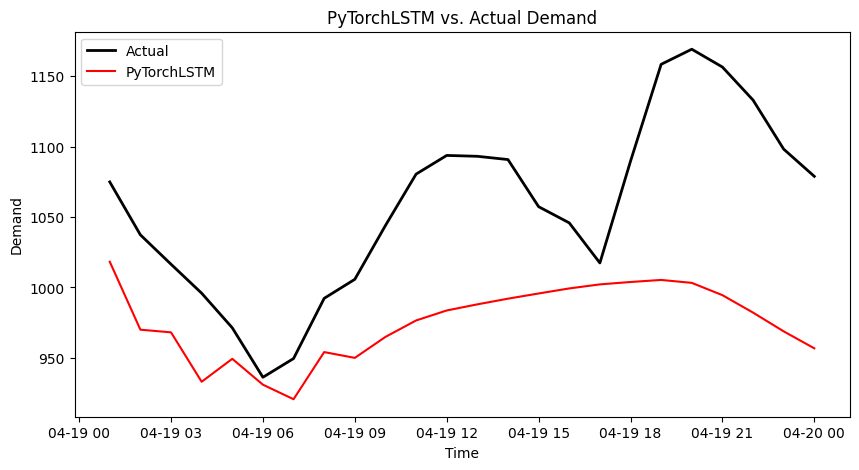

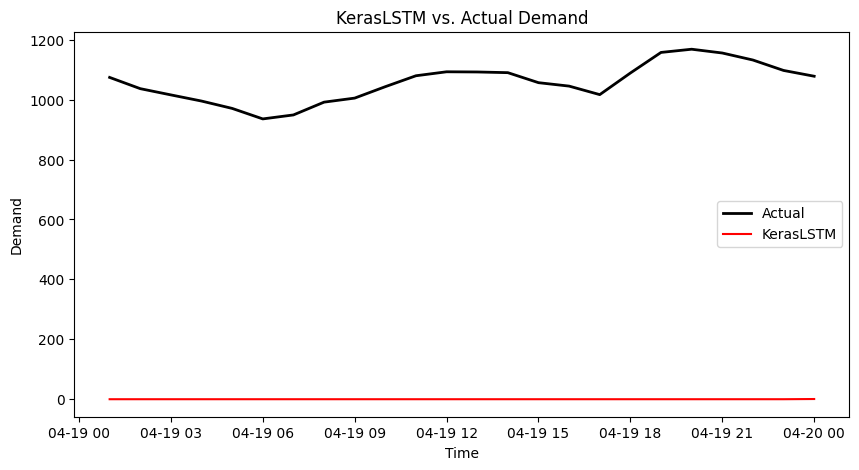

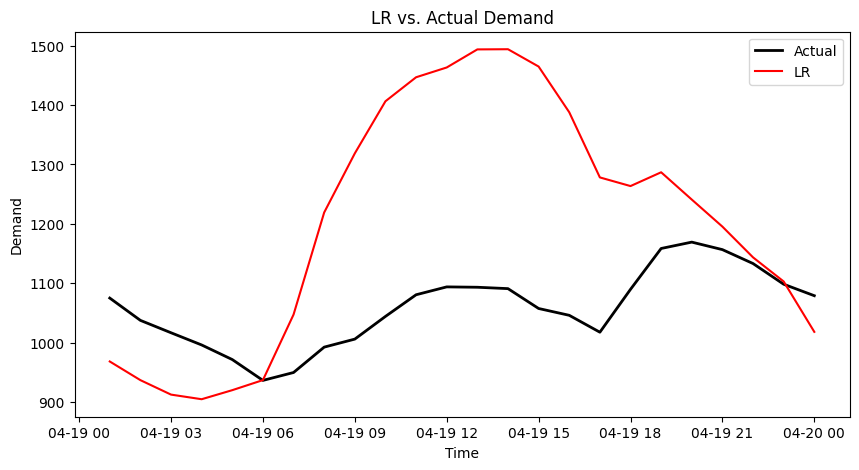

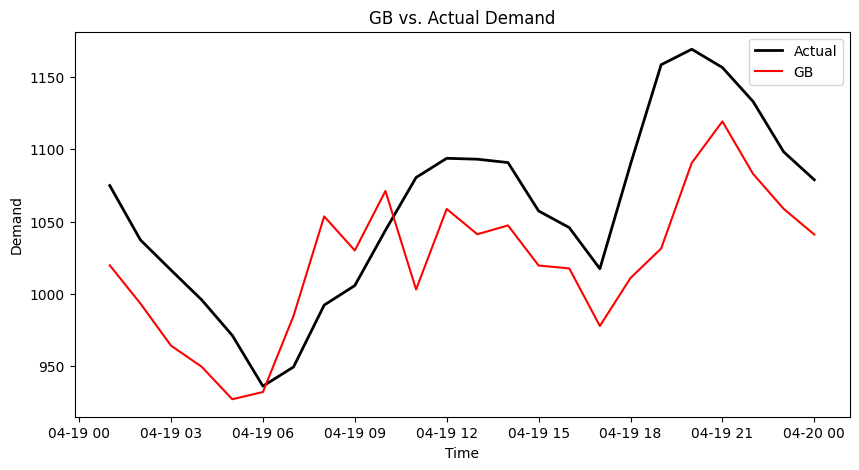

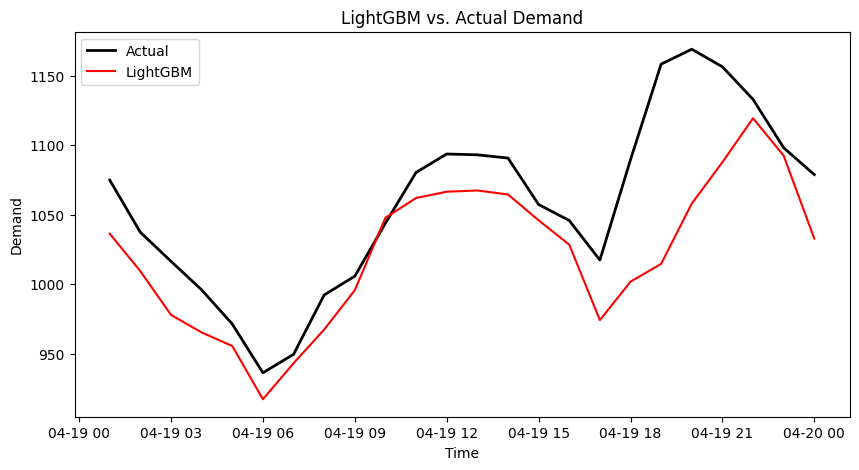

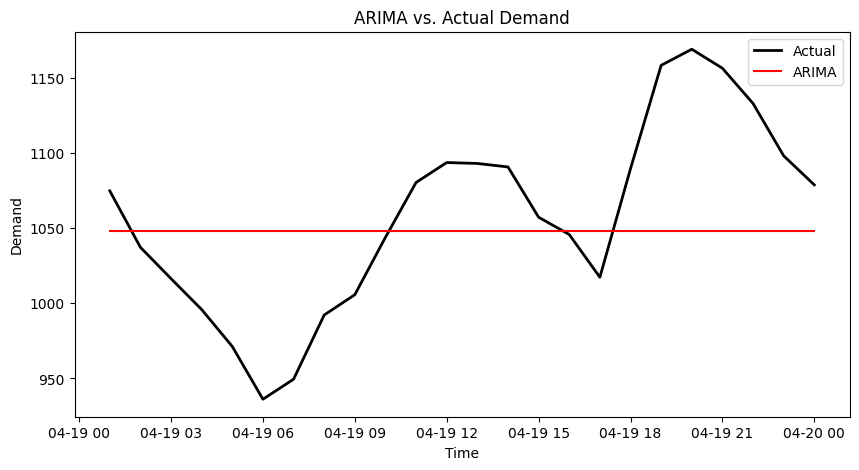

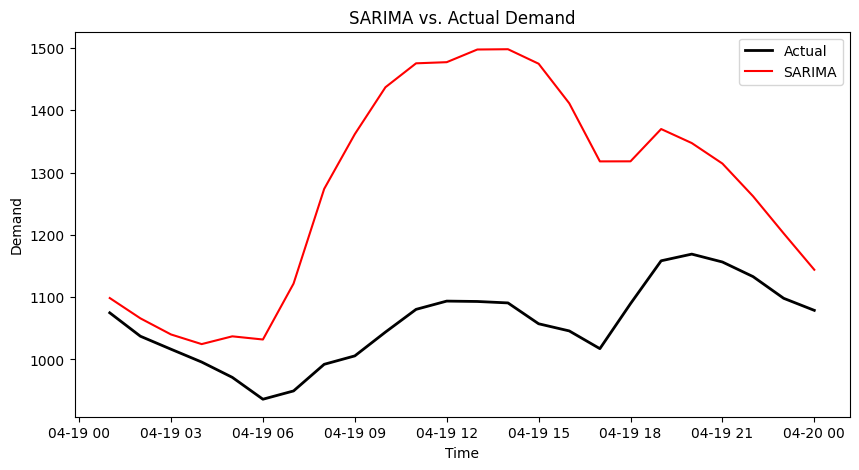

In [ ]:
import matplotlib.pyplot as plt


model_list = ['PyTorchLSTM', 'KerasLSTM', 'LR', 'GB', 'LightGBM', 'ARIMA', 'SARIMA']

# If you want to keep the **hourly** granularity (no resample), just use:
df_plot = big_results.copy()

# (Optional) If you want daily or monthly, you could do something like:
# df_plot = big_results.resample('D').mean()   # daily means
# df_plot = big_results.resample('M').mean()   # monthly means

for model_name in model_list:
    plt.figure(figsize=(10, 5))
    
    # Plot the actual demand in black
    plt.plot(df_plot.index, df_plot['True'], label='Actual', color='black', linewidth=2)
    
    # Plot this model's predictions in red (you can pick your color/style)
    plt.plot(df_plot.index, df_plot[model_name], label=model_name, color='red')
    
    # A few finishing touches
    plt.title(f"{model_name} vs. Actual Demand")
    plt.xlabel("Time")
    plt.ylabel("Demand")
    plt.legend()
    plt.show()
